In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [2]:
from doco.agents.supervisor import Supervisor
from doco.agents.summarizer.basic import Summarizer
from doco.agents.content_creator.basic import ContentCreator


supervisor_agent = Supervisor().build()
summarizer_agent = Summarizer().build()
contentcreator_agent = ContentCreator().build()

/home/octoopt/anaconda3/envs/llmapi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage
from doco.io._graph import AgentState, members, options

import functools

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result.content, name=name)]
    }

summarizer_node = functools.partial(agent_node, agent=summarizer_agent, name="Summarizer")
contentcreator_node = functools.partial(agent_node, agent=contentcreator_agent, name='ContentCreator')
# supervisor_node = functools.partial(agent_node, agent=supervisor_agent, name="Supervisor")

In [4]:
def supervisor_node(state):
    return supervisor_agent.invoke(state)

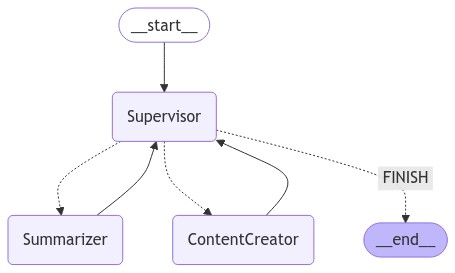

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(AgentState)

graph_builder.add_node("ContentCreator", contentcreator_node)
graph_builder.add_node("Summarizer", summarizer_node)
graph_builder.add_node("Supervisor", supervisor_node)


# Add entry point
graph_builder.add_edge(START, "Supervisor")

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    graph_builder.add_edge(member, "Supervisor")


# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
graph_builder.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

graph = graph_builder.compile()



from IPython.display import Image, display

try:
    image = Image(graph.get_graph().draw_mermaid_png(), format='png')
    display(image)
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
user_input = """I want to understand this passage correctly: 
Extraction-based summarization
Here, content is extracted from the original data, but the extracted content is not modified in any way. Examples of extracted content include key-phrases that can be used to "tag" or index a text document, or key sentences (including headings) that collectively comprise an abstract, and representative images or video segments, as stated above. For text, extraction is analogous to the process of skimming, where the summary (if available), headings and subheadings, figures, the first and last paragraphs of a section, and optionally the first and last sentences in a paragraph are read before one chooses to read the entire document in detail.[10] Other examples of extraction that include key sequences of text in terms of clinical relevance (including patient/problem, intervention, and outcome).[11]

Abstractive-based summarization
Abstractive summarization methods generate new text that did not exist in the original text.[12] This has been applied mainly for text. Abstractive methods build an internal semantic representation of the original content (often called a language model), and then use this representation to create a summary that is closer to what a human might express. Abstraction may transform the extracted content by paraphrasing sections of the source document, to condense a text more strongly than extraction. Such transformation, however, is computationally much more challenging than extraction, involving both natural language processing and often a deep understanding of the domain of the original text in cases where the original document relates to a special field of knowledge. "Paraphrasing" is even more difficult to apply to images and videos, which is why most summarization systems are extractive.

Aided summarization
Approaches aimed at higher summarization quality rely on combined software and human effort. In Machine Aided Human Summarization, extractive techniques highlight candidate passages for inclusion (to which the human adds or removes text). In Human Aided Machine Summarization, a human post-processes software output, in the same way that one edits the output of automatic translation by Google Translate."""

from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

for s in graph.stream(
    {"messages": [HumanMessage(content=user_input)]}
):
    if "__end__" not in s:
        print(s)
        print("----")

{'Supervisor': {'next': 'Summarizer'}}
----
{'Summarizer': {'messages': [HumanMessage(content='The passage discusses three main types of summarization methods: extraction-based summarization, abstractive-based summarization, and aided summarization.\n\nExtraction-based summarization involves extracting content from the original data without modification. Examples include key-phrases for indexing or abstracts, representative images/video segments, headings/subheadings, first/last paragraphs in sections, and first/last sentences of paragraphs. This process is similar to skimming a document.\n\nAbstractive-based summarization produces new text not present in the original content, often generating highly condensed summaries closer to human expression. Methods involve creating an internal semantic representation (language model) and using it to generate a summary that surpasses extraction methods by paraphrasing sections and transforming extracted content. However, this process is computati

In [7]:
user_input = "Write for me a joke about a rabbit and a bear"

# The config is the **second positional argument** to stream() or invoke()!
for s in graph.stream(
    {"messages": [HumanMessage(content=user_input)]}
):
    if "__end__" not in s:
        print(s)
        print("----")

KeyError: 'next'

In [ ]:
# # Test chatting

# def stream_graph_updates(user_input: str):
#     for event in graph.stream({"messages": [("user", user_input)]}):
#         for value in event.values():
#             print("Assistant:", value["messages"][-1].content)


# while True:
#     try:
#         user_input = input("User: ")
#         if user_input.lower() in ["quit", "exit", "q"]:
#             print("Goodbye!")
#             break

#         stream_graph_updates(user_input)
#     except:
#         # fallback if input() is not available
#         user_input = "What do you know about LangGraph?"
#         print("User: " + user_input)
#         stream_graph_updates(user_input)
#         break